# Business Intelligence for a Digital Music Store Using SQL

This project is an exercise in deriving business intelligence using SQLite and Python in Jupyter. The database being used is a sample database chinook that represents a music store, and is available for download [here](https://github.com/lerocha/chinook-database). We will first do some exploration on the data, and come up with business insights that can be answered using the database.

<img src="files/chinookdb.png">
Above is the schema for the Chinook database.

The content for this project will follow the according structure:
* **Connecting to SQL:** Connecting to the Chinook Database
* **Explore Chinook:** Introductory exploration into the database
* **Popular Genres:** What are the most commonly sold genres, and a recommendation for types of artists to be added to the store
* **Employee Sales Performance:** Look at employee sales performance, and determine if any of the employees are underperforming
* **International Market Analysis:** Analyse country level sales data to determine the best international markets to expand in
* **Purchase Restrictions:** Investigation into whether restricting album sales to full albums only or combinations of albums and singles would be more profitable

## Connecting to SQL

We elect to use the in-built SQLite3 module for this project as it allows for easy integration to Pandas.

In [252]:
# import relevant libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [253]:
# query function connected to the database
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

## Explore Chinook
Now that we have created a function with which we will run all our queries, we can begin to explore the database. We will begin by displaying all the tables in the database.

In [254]:
# function to display all tables in the database
def show_tables():
    tables = '''
    SELECT name, type FROM sqlite_master WHERE type IN (\"table\",\"view\");
    '''
    return run_query(tables)

In [255]:
# show all tables
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In accordance with the schema, there are 11 tables in this database.

Now let us confirm the columns in each table are correctly represented by the schema.

In [256]:
# function to get the columns of an individual table
def get_cols(table):
    q_table = 'SELECT * FROM ' + table + '''
    LIMIT 1
    '''
    return run_query(q_table).columns

In [257]:
# display the columns for each table in a dataframe
columns = pd.DataFrame()
# iterate over the table names in the database and perform an outer merge to display the information in a pretty table
for name in show_tables()['name']:
    next_col = pd.DataFrame({name : get_cols(name).tolist()})
    columns = pd.merge(left = columns, right = next_col, how = 'outer',left_index=True, right_index=True)
columns[columns.isnull()] = ''
columns

,album,artist,customer,employee,genre,invoice,invoice_line,media_type,playlist,playlist_track,track
0,album_id,artist_id,customer_id,employee_id,genre_id,invoice_id,invoice_line_id,media_type_id,playlist_id,playlist_id,track_id
1,title,name,first_name,last_name,name,customer_id,invoice_id,name,name,track_id,name
2,artist_id,,last_name,first_name,,invoice_date,track_id,,,,album_id
3,,,company,title,,billing_address,unit_price,,,,media_type_id
4,,,address,reports_to,,billing_city,quantity,,,,genre_id
5,,,city,birthdate,,billing_state,,,,,composer
6,,,state,hire_date,,billing_country,,,,,milliseconds
7,,,country,address,,billing_postal_code,,,,,bytes
8,,,postal_code,city,,total,,,,,unit_price
9,,,phone,state,,,,,,,


With the table information printed out, we can be confident that the schema accurately represents the database, and can start performing analysis over the database.

## Popular Genres
To start with, let us look at the most popular genres of music sold by the store, so as to be able to advise the company on the most profitable genres to stock.

The information we will need for this is:
* Genre
* Tracks sold within that genre
* Tracks sold within that genre as a percentage of total sales

As the data we need is in the invoice, invoice_list(each invoice could include multiple sales), and genre tables, and we need the sum of the quantity of sales in each invoice over all the invoices, we will need to use a few inner joins.

<img src="files/Query1.png">


In [258]:
# create a query that returns each genre, tracks sold in that genre, and the percentage of total sales for that genre
# g is the table genre, t is track, i_l is invoice_line, and i is invoice
q_genre = '''
WITH
    g AS (
        SELECT genre_id, name FROM genre
    ),
    t AS (
        SELECT t.track_id, t.genre_id, g.name genre FROM track t
        INNER JOIN g ON g.genre_id = t.genre_id
    ),
    i_l AS(
        SELECT 
            i_l.invoice_id, 
            i_l.track_id, 
            i_l.quantity, 
            t.genre_id,
            t.genre
        FROM invoice_line i_l
        INNER JOIN t ON t.track_id = i_l.track_id
        ),
    i AS (
        SELECT 
        i.customer_id, 
        i_l.invoice_id, 
        i_l.track_id, 
        i_l.quantity,
        i_l.genre_id,
        i_l.genre
        FROM invoice i
        INNER JOIN i_l ON i_l.invoice_id = i.invoice_id
        ),    
    totes AS (
        SELECT SUM(quantity) FROM i
    )
SELECT 
    genre "Genre", 
    SUM(quantity) "Tracks Sold", 
    CAST(SUM(quantity) AS FLOAT) / (SELECT CAST(SUM(quantity) AS FLOAT) FROM i) * 100 "Tracks Sold (Percentage)"
    FROM i 
GROUP BY genre
ORDER BY "Tracks Sold" DESC
'''

In [259]:
# run the query and print the resultant table
genre_info = run_query(q_genre)
genre_info

,Genre,Tracks Sold,Tracks Sold (Percentage)
0,Rock,2635,55.392054
1,Metal,619,13.012403
2,Alternative & Punk,492,10.342653
3,Latin,167,3.510616
4,R&B/Soul,159,3.342443
5,Blues,124,2.606685
6,Jazz,121,2.543620
7,Alternative,117,2.459533
8,Easy Listening,74,1.555602
9,Pop,63,1.324364


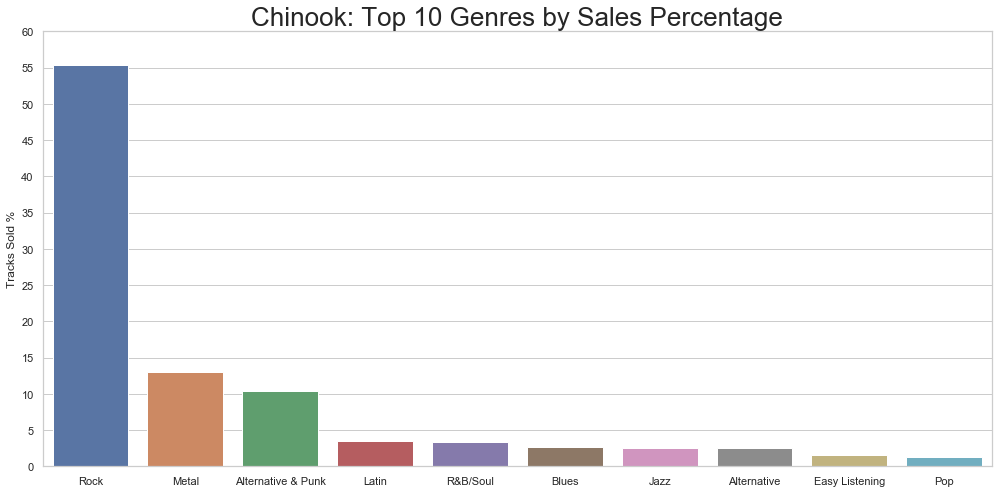

In [260]:
# plot the top 10 genres by sales percentages
fig, ax =plt.subplots(figsize = (17,8))
sns.set(style='whitegrid')
sns.barplot(x = "Genre", y = "Tracks Sold (Percentage)", data = genre_info.head(10), ax = ax)
ax.set_title('Chinook: Top 10 Genres by Sales Percentage', {'fontsize': 26})
a = ax.set_yticks(range(0,61,5), minor=False)
ax.set_xlabel('')
ax.set_ylabel('Tracks Sold %')
xticklabels = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

As shown, the top three genres for track sales are Rock, Metal and Alternative & Punk. As such, the naive first-glance analysis could indicate that the company should invest in stocking more of these three genres in their store.

However, more information would be needed to make such an assertion as it could simply be that the company is not stocking more popular artists from the other genres, or that the current customer base visits the store specifically for their particular assortment of music that is skewed more to the heavy genres. 

In data analysis it is important to look into the context of the data to glean our insights, but for this exercise we are more interested in the application of SQL querying techniques and hence this will suffice.

## Employee Sales Performance
For this analysis, we will look at the total sales to date per employee and try to determine which employee has the best performance.

The information we will need:
* Agent Name - The employee's name
* Sales Total - The sales totals to date will allow us to identify the top performing employee
* Hire Date - The date of hiring the agent would affect the total sales of the employee
* Birth Date - The age of an agent might affect their ability to sell
* Country - The country the agent is based in would also affect their ability to sell

To obtain this data, we will need to perform inner joins on the invoice, customer, and employee tables.

<img src="files/Query2.png">

In [261]:
# create a query that returns each employee, the sales total, hire date, birth date, and country of the employee
# i is invoice, c is customer, e is employee
employee_sales = '''
WITH
    i AS (
        SELECT customer_id, total
        FROM invoice
    ),
    c AS (
        SELECT c.support_rep_id, c.customer_id, i.total
        FROM customer c
        INNER JOIN i ON i.customer_id = c.customer_id 
    ),
    e AS (
        SELECT
        e.first_name || " " || e.last_name agent,
        e.hire_date,
        e.birthdate,
        e.country,
        e.employee_id,
        c.customer_id,
        c.total
        FROM employee e
        INNER JOIN c ON c.support_rep_id = e.employee_id
    )
SELECT agent, SUM(total) sales_total, hire_date, birthdate, country FROM e
GROUP BY agent
ORDER BY sales_total desc
'''

In [262]:
# run the query and plot the table
emp_sales_info = run_query(employee_sales)
run_query(employee_sales)

,agent,sales_total,hire_date,birthdate,country
0,Jane Peacock,1731.51,2017-04-01 00:00:00,1973-08-29 00:00:00,Canada
1,Margaret Park,1584.00,2017-05-03 00:00:00,1947-09-19 00:00:00,Canada
2,Steve Johnson,1393.92,2017-10-17 00:00:00,1965-03-03 00:00:00,Canada


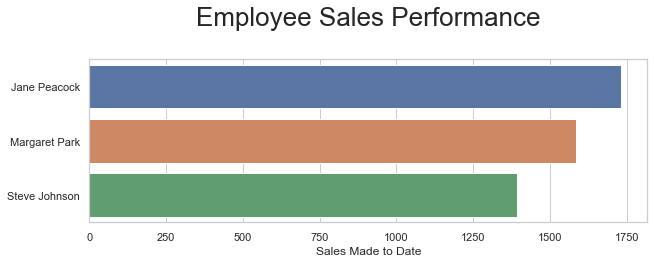

In [263]:
# plot a horizontal bargraph of the total sales for each employee
fig, ax =plt.subplots(figsize = (10,3))
sns.set(style='whitegrid')
sns.barplot(x = "sales_total", y = "agent", data = emp_sales_info, ax = ax)
ax.set_title('Employee Sales Performance\n', {'fontsize': 26})
ax.set_xlabel('Sales Made to Date')
ylabel = ax.set_ylabel('')

On first glance, it would seem that Jane Peacock outperformed both Steve Johnson and Margeret Park. However, it becomes apparent upon looking at the other information that we have collected, that this may not entirely be the case. We see that Steve was hired roughly 5 months later than both Jane and Margeret, and that is about 5 months of not making sales that would heavily skew the numbers. Further, Margaret is about 30 years older than the other two employees and this could weigh heavily on her ability to make sales, being an elderly person.

At the moment, their sales volumes seem to correspond highly with their hire dates. A more precise way to determine the efficiency of the employees would be to plot the individual average sales over set time periods, as different time periods would result in different overall sales.

## International Market Analysis
As an international company, we would be interested in which would be the best countries to expand our markets in.

We will extract and analyse:
* Country - The countries with more than one customer, as well as the rest combined to a cell titled others
* Unique Customers - The unique number of customers in each country
* Customer Total Sales - The total earned from sales in each country
* Customer Average Sale - The average earned from each sale per customer
* Customer Average Order- The average earned from each order per customer

We will need to perform inner joins on the customer and invoice to obtain this data, as well as some wrangling to extract the 'others' cell.

<img src="files/Query3.png">

Additionally, for this particular case, we want to sort the countries by the average order per customer to find the countries with the highest paying customers, whilst leaving the 'others' cell at the end. To do this, we will have to create an additional sorting row to sort by at the end. 

In [264]:
# create a query that returns each country, customers, country, total sales, average sale per customer, 
# and average order of that country
# c is the customer table, i is the invoice table, j is the invoice_table modified with inner joins with c and aggregate values
# final is the data from j further aggregated with the last step of sorting the 'other' row left out
country_query = '''
WITH 
c AS (
    SELECT 
        customer_id,
        country
    FROM customer
),
i AS (
    SELECT
        customer_id,
        COUNT(invoice_id) number_of_orders,
        SUM(total) customer_total
    FROM invoice
    GROUP BY customer_id
),
j AS (
    SELECT 
        c.country country_0,
        COUNT(c.customer_id) customers, 
        SUM(i.customer_total) total_sales, 
        ROUND(SUM(i.customer_total)/COUNT(c.customer_id),2) avg_sale,
        SUM(i.number_of_orders) number_of_orders
    FROM i
    INNER JOIN c ON c.customer_id=i.customer_id
    GROUP BY c.country
    ORDER BY total_sales DESC
),
final as (SELECT 
        CASE
            WHEN customers = 1 THEN "Other"
            ELSE country_0
            END as "Country",
        SUM(customers) "Customers", 
        SUM(total_sales) "Total Sales", 
        ROUND(SUM(total_sales)/SUM(customers),2) "Average Sale",
        ROUND(SUM(total_sales)/SUM(number_of_orders),2) "Average Order"
    FROM j
    GROUP BY "Country"
    ORDER BY "Average Order" DESC)
SELECT "Country", "Customers", "Total Sales", "Average Sale", "Average Order" FROM
    (
    SELECT
        *,
        CASE
            WHEN "Country" = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM final
    )
ORDER BY sort ASC    
'''
run_query(country_query)

,Country,Customers,Total Sales,Average Sale,Average Order
0,Czech Republic,2,273.24,136.62,9.11
1,United Kingdom,3,245.52,81.84,8.77
2,India,2,183.15,91.58,8.72
3,Germany,4,334.62,83.66,8.16
4,USA,13,1040.49,80.04,7.94
5,France,5,389.07,77.81,7.78
6,Canada,8,535.59,66.95,7.05
7,Brazil,5,427.68,85.54,7.01
8,Portugal,2,185.13,92.57,6.38
9,Other,15,1094.94,73.00,7.45


Going purely from this data, we might conclude that Czech Republic, United Kingdom, and India are good countries to expand our market into. However, we should be weary that the sample size is very small and not really statistically significant enough to motivate big spending in marketing efforts yet. It would be a better approach to run small campaigns in these 3 countries to get more data to ensure that these trends generally hold for customers in those countries.

## Purchase Restrictions
The Chinook store is set up such that customers must either purchase a full album or purchase collections of tracks individually, but not both. If it turns out that customers do not usually purchase full albums, it might be more profitable to only purchase the most popular tracks from each album from record companies.

The relevant columns we need for this analysis are:
* Album Purchase - If each invoice was for an album or collection of individual tracks
* Transactions - The number of transactions for each particular type of purchase
* Percentage of Transactions - The percentage of transactions for each particular type of purchase

<img src="files/Query4.png">

This time we only need the invoice_line and track tables, but we will need a way to determine if an invoice is for a full album or a collection of individual tracks. To do this, we need to compare the tracks from the album of the first track of an invoice with the entire invoice. If there are tracks in an invoice but not on the album of the first track, or tracks in that same album that are not on the invoice, then that invoice is not an album purchase.

In [265]:
# create a query that returns if invoices were full album purchases or not, the number of invoices for each category, 
# and the percentage of those invoices in each category
# t is track, t2 is track, i_l is invoice line, i_l2 is invoice line
# i_f is invoice_id and extracted first track from invoice_line, i_f2 is invoice_id, first track, and if the invoice is an album purchase
album_query = '''
WITH 
i_f AS 
(SELECT invoice_id, min(track_id) first_track FROM invoice_line
GROUP BY invoice_id),
i_f2 AS
(SELECT
        i_f.*,
        CASE
            WHEN
                (SELECT t.track_id from track t
                   WHERE t.album_id = (SELECT t2.album_id from track t2
                                       WHERE t2.track_id = i_f.first_track) 
                EXCEPT
                    SELECT i_l2.track_id from invoice_line i_l2
                        WHERE i_l2.invoice_id = i_f.invoice_id
                ) IS NULL
                AND
                (SELECT i_l2.track_id from invoice_line i_l2
                        WHERE i_l2.invoice_id = i_f.invoice_id
                EXCEPT
                    SELECT t.track_id from track t
                   WHERE t.album_id = (SELECT album_id from track t2
                                       WHERE t2.track_id = i_f.first_track) 
                
                
                ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "Album Purchase"
     FROM i_f)
SELECT 
"Album Purchase",
COUNT(invoice_id) "Transactions",
ROUND(CAST(count(invoice_id) AS FLOAT) /  
(SELECT COUNT(*) FROM invoice) * 100
,2) "Percentage of Transactions"
FROM i_f2
GROUP BY "Album Purchase"
'''

In [266]:
# run the query and print to page
albump_info = run_query(album_query)
albump_info

,Album Purchase,Transactions,Percentage of Transactions
0,no,500,81.43
1,yes,114,18.57


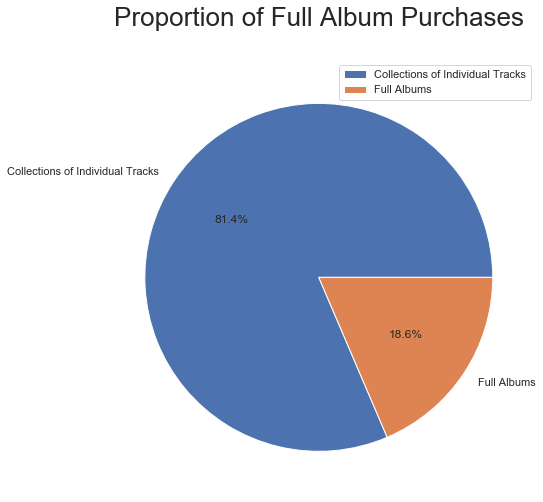

In [267]:
# plot the proprotion of full album purchases
fig, ax = plt.subplots(figsize = (8,8))
labels = ['Collections of Individual Tracks', 'Full Albums']
album_plot = albump_info.plot.pie(y = 'Transactions', ax=ax, labels=labels , autopct='%1.1f%%')
ax.set_title('Proportion of Full Album Purchases\n', {'fontsize': 26})
ax.legend(loc = 'upper right')
ylabel = ax.set_ylabel('')

We see that about one fifth of sales included full album sales. Thus it is likely detrimental to the store to employ the strategy of only purchasing select tracks from popular albums as they stand to lose one fifth of total revenue.